Configuration loaded.

Parsing utilities ready.

Raw data: 21,321 rows, 29 columns
Found 6 restaurants: ['Swaad', 'Aura Pizzas', 'Dilli Burger Adda', 'Tandoori Junction', 'The Chicken Junction', 'Masala Junction']
Restaurant menus created: {'Aura Pizzas': 76, 'Dilli Burger Adda': 64, 'Masala Junction': 13, 'Swaad': 94, 'Tandoori Junction': 37, 'The Chicken Junction': 21}
Swaad's menu: ['AAC Fried Chicken Burger', 'AAC Fried Paneer Burger', 'AAC Grilled Chicken Burger', 'AAC Grilled Chicken Burger .', 'AAC Grilled Paneer Burger', 'AAC Saucy Fries', 'AAC Signature Crisper Fries', 'AAC Signature Fries', 'AAC Signature Krispers', 'AAC Special Slaw', 'Angara Aloo Tuk Tuki', 'Angara Grilled Paneer (8 pcs)', 'Angara Rice', 'Angara Sauce', 'Animal Fries', 'Animal Fries .', 'Bone in Angara Grilled Chicken', 'Bone in Angara Grilled Chicken .', 'Bone in Jamaican Grilled Chicken', 'Bone in Jamaican Grilled Chicken .', 'Bone in Jamaican Grilled Chicken Quarter + Angara Rice', 'Bone in Kabuli Grille

/Users/saugatshakya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/saugatshakya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/saugatshakya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/saugatshakya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/saugatshakya/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, 

Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
CV R²: 0.459
Training lightgbm on 2,025 hours (all targets)...
Model trained.


Best model: lightgbm (CV R²: 0.459)

Model Comparison:
xgboost: CV R² = 0.450
random_forest: CV R² = 0.451
lightgbm: CV R² = 0.459

Evaluating lightgbm on test hours...
Test R² for lightgbm: -0.045

Next hour (Swaad):
                               dish  predicted_qty
0  Bone in Jamaican Grilled Chicken              1
1                     Herbed Potato              0
2                      Salted Fries              0
3                       Onion Rings              0
4       Tipsy Tiger Fresh Lime Soda              0
5                   Peri Peri Fries              0
6                      Garlic Aioli              0
7  Grilled Chicken Peri Peri Tender              0
8       Fried Chicken Angara Tender              0
9  Grilled Chicken Smoky BBQ Tender              0

Full day forecast (2025-10-29, Swaad):
                           

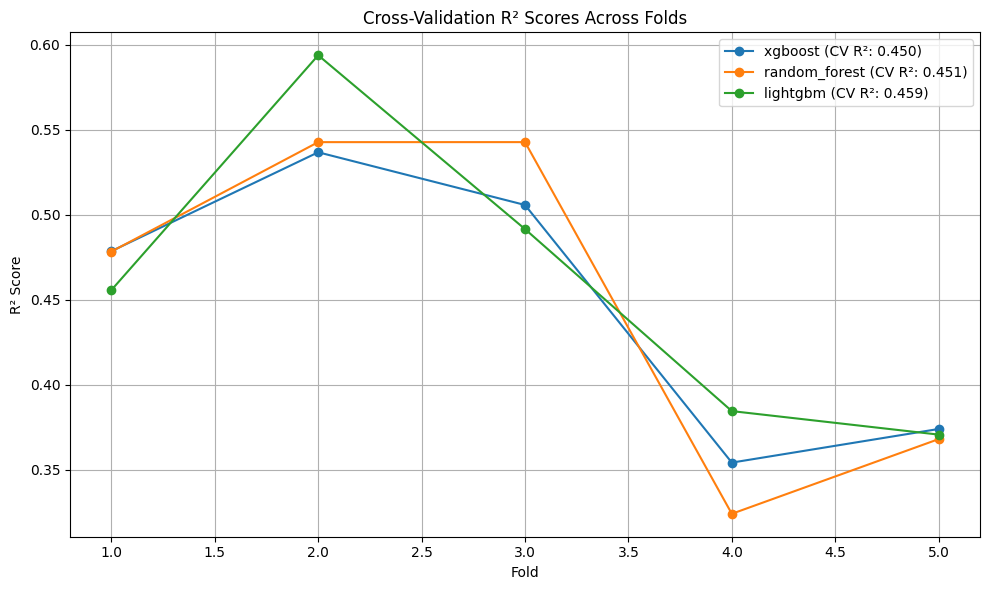

Loss graph saved → models/cv_r2_comparison.png

Model saved → models/dish_forecaster_final.pkl


In [ ]:
# =============================================================================
# DISH DEMAND FORECASTER – FINAL POLISHED NOTEBOOK
# Author: Your Name
# Date: 2025-10-27
# Goal: Predict hourly demand for top-K dishes per restaurant with model comparison
# =============================================================================

# --------------------------------------------------------------
# 1. IMPORTS & CONFIG
# --------------------------------------------------------------
import os
import re
import joblib
import warnings
from collections import Counter
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings("ignore")

# ── CONFIG ───────────────────────────────────────────────────
DATA_PATH      = "../data/data.csv"  # Adjust path as needed
TOP_K          = 50
LAGS           = [1, 2, 3, 6, 12, 24]
WINDOWS        = [3, 6, 12, 24]
USE_SCALER     = True
TRAIN_FRAC     = 0.8
RANDOM_STATE   = 42
MODEL_DIR      = "models"
CV_FOLDS       = 5
os.makedirs(MODEL_DIR, exist_ok=True)

print("Configuration loaded.\n")

# --------------------------------------------------------------
# 2. PARSING UTILITIES
# --------------------------------------------------------------
def parse_order_items(order_str: str) -> List[Tuple[str, int]]:
    """Parse '2 x Pizza, 1 x Coke' → [('Pizza', 2), ('Coke', 1)]"""
    if pd.isna(order_str):
        return []
    return [(name.strip(), int(qty))
            for qty, name in re.findall(r"(\d+)\s*[xX]\s*([^,]+)", order_str)]

def expand_items(df: pd.DataFrame) -> pd.DataFrame:
    """Expand 'Items in order' into a list of (item, qty) tuples."""
    df["expanded_items"] = df["Items in order"].fillna("").apply(parse_order_items)
    return df

print("Parsing utilities ready.\n")

# --------------------------------------------------------------
# 3. LOAD & PREPROCESS
# --------------------------------------------------------------
def load_and_prepare_data(path: str) -> Tuple[pd.DataFrame, Dict[str, List[str]]]:
    """Load and preprocess raw order data, returning DataFrame and restaurant menus."""
    df = pd.read_csv(path)
    print(f"Raw data: {df.shape[0]:,} rows, {df.shape[1]} columns")

    dt_col = next((c for c in df.columns
                   if "order" in c.lower() and ("placed" in c.lower() or "date" in c.lower())), None)
    if not dt_col:
        raise ValueError("No order datetime column found.")
    df["order_datetime"] = pd.to_datetime(df[dt_col], errors="coerce")
    df = df.dropna(subset=["order_datetime"]).copy()
    df["order_hour"] = df["order_datetime"].dt.floor("h")

    rest_col = "Restaurant name"
    if rest_col not in df.columns:
        raise ValueError(f"'{rest_col}' column not found.")
    df[rest_col] = df[rest_col].str.strip()
    unique_restaurants = df[rest_col].unique()
    print(f"Found {len(unique_restaurants)} restaurants: {list(unique_restaurants)}")
    df = pd.get_dummies(df, columns=[rest_col], prefix="rest", dtype=int)

    if "Items in order" not in df.columns:
        raise ValueError("'Items in order' column not found.")
    df = expand_items(df)

    rest_menus = {}
    rest_cols = [c for c in df.columns if c.startswith("rest_")]
    for rest_col in rest_cols:
        rest_name = rest_col[5:]
        rest_orders = df[df[rest_col] == 1]["expanded_items"]
        menu = set()
        for items in rest_orders:
            menu.update(name for name, _ in items)
        rest_menus[rest_name] = sorted(list(menu))
    print(f"Restaurant menus created: { {k: len(v) for k, v in rest_menus.items()} }")
    print("Swaad's menu:", rest_menus.get("Swaad", []))

    print(f"Pre-processed: {len(df):,} orders")
    return df, rest_menus

df, rest_menus = load_and_prepare_data(DATA_PATH)

# --------------------------------------------------------------
# 4. BUILD HOURLY AGGREGATED TABLE
# --------------------------------------------------------------
def build_hourly_table(df: pd.DataFrame, top_k: int) -> Tuple[pd.DataFrame, List[str]]:
    """Aggregate orders to hourly level with top-K dishes."""
    all_items = Counter()
    for items in df["expanded_items"]:
        all_items.update({name: qty for name, qty in items})
    top_dishes = [name for name, _ in all_items.most_common(top_k)]
    print(f"Top-{len(top_dishes)} dishes selected (sample: {top_dishes[:5]})")

    hour_idx = pd.date_range(
        start=df["order_hour"].min().floor("D"),
        end=df["order_hour"].max().ceil("D"),
        freq="h"
    )
    agg = pd.DataFrame(index=hour_idx)
    agg.index.name = "order_hour"

    agg["hour_of_day"] = agg.index.hour
    agg["day_of_week"] = agg.index.dayofweek
    agg["is_weekend"] = agg.index.dayofweek.isin([5, 6]).astype(int)

    for dish in top_dishes:
        agg[f"dish__{dish}"] = 0
    agg["total_orders"] = 0

    rest_cols = [c for c in df.columns if c.startswith("rest_")]
    for col in rest_cols:
        agg[col] = 0

    for hour, group in df.groupby("order_hour"):
        if hour not in agg.index:
            continue
        agg.loc[hour, "total_orders"] = len(group)
        for col in rest_cols:
            agg.loc[hour, col] = 1 if group[col].sum() > 0 else 0
        hour_counts = Counter()
        for items in group["expanded_items"]:
            hour_counts.update({name: qty for name, qty in items})
        for dish in top_dishes:
            agg.loc[hour, f"dish__{dish}"] = hour_counts.get(dish, 0)

    agg = agg[agg["total_orders"] > 0].copy()
    print(f"Aggregated {len(agg):,} active hours.")
    return agg, top_dishes

agg, top_dishes = build_hourly_table(df, TOP_K)

# --------------------------------------------------------------
# 5. FEATURE ENGINEERING (lags + rolling)
# --------------------------------------------------------------
def add_temporal_features(agg: pd.DataFrame,
                         lags: List[int],
                         windows: List[int]) -> pd.DataFrame:
    """Add lag and rolling window features."""
    df = agg.copy()

    for lag in lags:
        df[f"total_orders_lag_{lag}"] = df["total_orders"].shift(lag)
        for dish in top_dishes:
            df[f"dish__{dish}_lag_{lag}"] = df[f"dish__{dish}"].shift(lag)

    for w in windows:
        df[f"total_orders_rollmean_{w}"] = df["total_orders"].rolling(w, min_periods=1).mean()
        for dish in top_dishes:
            df[f"dish__{dish}_rollmean_{w}"] = df[f"dish__{dish}"].rolling(w, min_periods=1).mean()

    df = df.dropna().reset_index()
    print(f"Feature engineering → {df.shape[0]:,} rows, {df.shape[1]} cols")
    return df

agg_with_hour = add_temporal_features(agg, LAGS, WINDOWS)

# --------------------------------------------------------------
# 6. TRAIN / TEST SPLIT (time-based)
# --------------------------------------------------------------
def ensure_restaurant_coverage(train_agg: pd.DataFrame, test_agg: pd.DataFrame,
                              rest_cols: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Ensure all restaurants appear in training data."""
    train_rest = set([c for c in rest_cols if train_agg[c].sum() > 0])
    test_rest = set([c for c in rest_cols if test_agg[c].sum() > 0])
    missing = test_rest - train_rest
    if missing:
        print(f"Warning: {len(missing)} restaurants in test but not in train: {missing}")
        for col in missing:
            rest_data = test_agg[test_agg[col] == 1].head(1)
            if not rest_data.empty:
                train_agg = pd.concat([train_agg, rest_data])
                test_agg = test_agg.drop(rest_data.index)
        print("Adjusted train/test split to include all restaurants.")
    return train_agg, test_agg

split_time = agg_with_hour["order_hour"].quantile(TRAIN_FRAC)
train_agg = agg_with_hour[agg_with_hour["order_hour"] < split_time].copy()
test_agg = agg_with_hour[agg_with_hour["order_hour"] >= split_time].copy()
rest_cols = [c for c in agg_with_hour.columns if c.startswith("rest_")]
train_agg, test_agg = ensure_restaurant_coverage(train_agg, test_agg, rest_cols)
full_agg = agg_with_hour.set_index("order_hour")

print(f"Train hours: {len(train_agg):,} | Test hours: {len(test_agg):,}")

# --------------------------------------------------------------
# 7. FEATURE / TARGET LISTS
# --------------------------------------------------------------
feature_cols = [c for c in train_agg.columns
                if not c.startswith("dish__") and c != "order_hour"]
rest_cols = [c for c in feature_cols if c.startswith("rest_")]
target_cols = [f"dish__{d}" for d in top_dishes]

print(f"Features: {len(feature_cols)} (restaurants: {len(rest_cols)})")
print(f"Targets: {len(target_cols)}")

# --------------------------------------------------------------
# 8. MODEL DEFINITION & TUNING
# --------------------------------------------------------------
def tune_model(estimator, param_grid: dict, X: np.ndarray, y: np.ndarray, cv_splits) -> dict:
    """Perform grid search with time-series cross-validation on a single target."""
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="r2",
        cv=cv_splits,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X, y)
    fold_scores = [grid_search.cv_results_[f"split{i}_test_score"][grid_search.best_index_]
                   for i in range(CV_FOLDS)]
    return {
        "best_params": grid_search.best_params_,
        "cv_r2": grid_search.best_score_,
        "fold_r2_scores": fold_scores
    }

class DishDemandForecaster:
    def __init__(self, rest_menus: Dict[str, List[str]], model_type: str = "xgboost"):
        self.top_dishes = top_dishes
        self.feature_cols = feature_cols
        self.target_cols = target_cols
        self.rest_menus = rest_menus
        self.model_type = model_type
        self.scaler = StandardScaler() if USE_SCALER else None
        if model_type == "xgboost":
            self.base_estimator = xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1,
                                                  objective="reg:squarederror")
            self.param_grid = {
                "n_estimators": [100, 200, 400],
                "max_depth": [3, 5, 7],
                "learning_rate": [0.01, 0.05, 0.1]
            }
        elif model_type == "random_forest":
            self.base_estimator = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
            self.param_grid = {
                "n_estimators": [100, 200, 400],
                "max_depth": [None, 10, 20],
                "min_samples_split": [2, 5]
            }
        elif model_type == "lightgbm":
            self.base_estimator = lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1,
                                                   verbose=-1)
            self.param_grid = {
                "n_estimators": [100, 200, 400],
                "max_depth": [3, 5, 7],
                "learning_rate": [0.01, 0.05, 0.1]
            }
        else:
            raise ValueError("Model type must be 'xgboost', 'random_forest', or 'lightgbm'")
        self.model = MultiOutputRegressor(self.base_estimator)
        self._warned = set()

    def fit(self, df: pd.DataFrame):
        """Train the forecaster with hyperparameter tuning on a single target."""
        X = df[self.feature_cols].select_dtypes(include=[np.number])
        Y = df[self.target_cols]
        if self.scaler:
            X = pd.DataFrame(self.scaler.fit_transform(X), index=X.index, columns=X.columns)

        # Select most frequent dish for tuning
        dish_counts = Y.sum().sort_values(ascending=False)
        if dish_counts.empty:
            raise ValueError("No valid target data for tuning.")
        primary_target = dish_counts.index[0]
        y_single = Y[primary_target]

        print(f"Tuning {self.model_type} on primary target: {primary_target}...")
        tscv = TimeSeriesSplit(n_splits=CV_FOLDS)
        tuning_results = tune_model(self.base_estimator, self.param_grid, X.values, y_single, tscv)
        print(f"Best params: {tuning_results['best_params']}")
        print(f"CV R²: {tuning_results['cv_r2']:.3f}")
        self.model.estimator.set_params(**tuning_results["best_params"])

        print(f"Training {self.model_type} on {X.shape[0]:,} hours (all targets)...")
        self.model.fit(X.values, Y.values)
        print("Model trained.\n")
        return tuning_results["cv_r2"], tuning_results["fold_r2_scores"]

    def predict(self, dt_hour: pd.Timestamp, restaurant: str = None,
                round_int: bool = True) -> pd.DataFrame:
        """Predict dish demand, restricted to restaurant's menu."""
        dt_hour = pd.to_datetime(dt_hour).floor("h")
        past = full_agg[full_agg.index < dt_hour]
        if past.empty:
            raise ValueError(f"No history before {dt_hour}")
        last = past.iloc[-1]

        row = pd.Series(0.0, index=self.feature_cols)
        row["hour_of_day"] = dt_hour.hour
        row["day_of_week"] = dt_hour.dayofweek
        row["is_weekend"] = int(dt_hour.dayofweek in [5, 6])

        if restaurant:
            col = f"rest_{restaurant.strip()}"
            if col in self.feature_cols:
                row[col] = 1
            elif restaurant not in self._warned:
                print(f"Warning: Restaurant '{restaurant}' not recognized. Using average behavior.")
                self._warned.add(restaurant)

        lag_like = [c for c in self.feature_cols if c.startswith(("total_orders_lag_",
                                                                  "total_orders_rollmean_",
                                                                  "dish__"))]
        for c in lag_like:
            row[c] = last.get(c, 0)

        X_in = pd.DataFrame([row])
        if self.scaler:
            X_in = pd.DataFrame(self.scaler.transform(X_in), columns=X_in.columns)
        X_in = X_in.reindex(columns=self.feature_cols, fill_value=0)

        pred = self.model.predict(X_in)[0]
        if round_int:
            pred = np.maximum(np.round(pred).astype(int), 0)

        result = pd.DataFrame({"dish": self.top_dishes, "predicted_qty": pred})
        if restaurant and restaurant in self.rest_menus:
            valid_dishes = self.rest_menus[restaurant]
            result = result[result["dish"].isin(valid_dishes)]
            if result.empty:
                print(f"Warning: No valid dishes found for '{restaurant}' in top-{TOP_K} dishes.")
        return result.sort_values("predicted_qty", ascending=False).reset_index(drop=True)

# --------------------------------------------------------------
# 9. MODEL COMPARISON & TRAINING
# --------------------------------------------------------------
model_types = ["xgboost", "random_forest", "lightgbm"]
model_results = {}

X_train = train_agg[feature_cols].select_dtypes(include=[np.number])
Y_train = train_agg[target_cols]
if USE_SCALER:
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

for model_type in model_types:
    print(f"\nTraining and tuning {model_type}...")
    forecaster = DishDemandForecaster(rest_menus, model_type=model_type)
    cv_r2, fold_r2_scores = forecaster.fit(train_agg.drop(columns=["order_hour"]))
    model_results[model_type] = {
        "forecaster": forecaster,
        "cv_r2": cv_r2,
        "fold_r2_scores": fold_r2_scores
    }

# Select best model
best_model_type = max(model_results, key=lambda x: model_results[x]["cv_r2"])
best_forecaster = model_results[best_model_type]["forecaster"]
print(f"\nBest model: {best_model_type} (CV R²: {model_results[best_model_type]['cv_r2']:.3f})")

# Print comparison
print("\nModel Comparison:")
for model_type, results in model_results.items():
    print(f"{model_type}: CV R² = {results['cv_r2']:.3f}")

# --------------------------------------------------------------
# 10. EVALUATE ON TEST SET
# --------------------------------------------------------------
preds = []
print(f"\nEvaluating {best_model_type} on test hours...")
for _, row in test_agg.iterrows():
    dt = row["order_hour"]
    active = [c for c in rest_cols if row[c] == 1]
    rest_name = active[0][5:] if active else None
    pred = best_forecaster.predict(dt, restaurant=rest_name, round_int=False)
    pred_full = np.zeros(len(target_cols))
    for i, dish in enumerate(top_dishes):
        if dish in pred["dish"].values:
            pred_full[i] = pred.loc[pred["dish"] == dish, "predicted_qty"].iloc[0]
    preds.append(pred_full)

Y_test = test_agg[target_cols].values
test_r2 = r2_score(Y_test, np.array(preds))
print(f"Test R² for {best_model_type}: {test_r2:.3f}")

# --------------------------------------------------------------
# 11. INFERENCE HELPERS
# --------------------------------------------------------------
def predict_next_hour(restaurant: str = None):
    """Predict demand for the next hour."""
    next_h = full_agg.index.max() + pd.Timedelta(hours=1)
    return best_forecaster.predict(next_h, restaurant=restaurant)

def forecast_day(date: str, restaurant: str = None):
    """Forecast demand for all hours in a day."""
    hours = pd.date_range(f"{date} 00:00", f"{date} 23:00", freq="h")
    results = []
    for h in hours:
        pred = best_forecaster.predict(h, restaurant=restaurant)
        pred["hour"] = h.strftime("%H:%M")
        results.append(pred)
    return pd.concat(results).reset_index(drop=True)

# Example usage
print("\nNext hour (Swaad):")
print(predict_next_hour("Swaad").head(10))

print("\nFull day forecast (2025-10-29, Swaad):")
daily = forecast_day("2025-10-29", "Swaad")
print(daily.head(15))

# --------------------------------------------------------------
# 12. LOSS GRAPH
# --------------------------------------------------------------
plt.figure(figsize=(10, 6))
for model_type, results in model_results.items():
    fold_r2_scores = results["fold_r2_scores"]
    plt.plot(range(1, CV_FOLDS + 1), fold_r2_scores, marker='o', label=f"{model_type} (CV R²: {results['cv_r2']:.3f})")
plt.xlabel("Fold")
plt.ylabel("R² Score")
plt.title("Cross-Validation R² Scores Across Folds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, "cv_r2_comparison.png"))
plt.show()
print(f"Loss graph saved → {MODEL_DIR}/cv_r2_comparison.png")

# --------------------------------------------------------------
# 13. SAVE MODEL + FULL HISTORY
# --------------------------------------------------------------
joblib.dump({
    "model": best_forecaster,
    "top_dishes": top_dishes,
    "feature_cols": feature_cols,
    "rest_menus": rest_menus,
    "full_agg": full_agg
}, os.path.join(MODEL_DIR, "dish_forecaster_final.pkl"))

print(f"\nModel saved → {MODEL_DIR}/dish_forecaster_final.pkl")